## Understanding review usefulness through attention using Hierarchical Attention Network (HAN)


In [0]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import pickle
import pandas as pd
import json
import gzip
import matplotlib.pyplot as plt

import nltk
from fastai.text import Tokenizer, Vocab, SpacyTokenizer, WeightDropout, EmbeddingDropout
from gensim.utils import tokenize
from sklearn.metrics import accuracy_score, f1_score
from textblob import TextBlob

use_cuda = torch.cuda.is_available()
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

model_name = 'amazon_electronics_useful'

In this notebook, we will be using a **subset of the Amazon Electronics 5-core review dataset**, and GloVe 300D word embeddings.

Original dataset is obtained from https://nijianmo.github.io/amazon/index.html. Reviews from other Amazon categories can also be obtained from the same link.

In [3]:
path = '/tmp/'

# Glove 300D embeddings
!gdown --id '1Bn1s3w4eETF3yDHJmhLXNOPSN7q29sey' --output '/tmp/glove.6B.300d.txt'

# Amazon Electronics dataset
!gdown --id '1JE38UqpHNFycbi3B6gOu4OksjVhck8bP' --output '/tmp/Electronics_5.csv'
dataset_filename = 'Electronics_5.csv'
df = pd.read_csv(path + dataset_filename)

Downloading...
From: https://drive.google.com/uc?id=1Bn1s3w4eETF3yDHJmhLXNOPSN7q29sey
To: /tmp/glove.6B.300d.txt
1.04GB [00:13, 75.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JE38UqpHNFycbi3B6gOu4OksjVhck8bP
To: /tmp/Electronics_5.csv
548MB [00:12, 42.4MB/s]


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df['reviewText'] = df['reviewText'].astype(str)
df['vote'] = df['vote'].str.replace(',','').fillna(0)
df['overall'] = df['overall'].fillna(0)
df['vote'] = pd.to_numeric(df['vote'])
df['overall'] = pd.to_numeric(df['overall'])
df = df.filter(['vote','overall','reviewText', 'reviewTime'], axis=1)
df.columns = ['useful', 'stars', 'text', 'date']
df

,useful,stars,text,date
0,67,5.0,This is the best novel I have read in 2 or 3 y...,"09 18, 1999"
1,5,3.0,"Pages and pages of introspection, in the style...","10 23, 2013"
2,4,5.0,This is the kind of novel to read when you hav...,"09 2, 2008"
3,13,5.0,What gorgeous language! What an incredible wri...,"09 4, 2000"
4,8,3.0,I was taken in by reviews that compared this b...,"02 4, 2000"
...,...,...,...,...
999995,2,5.0,The Netgear Router is my first experience with...,"06 19, 2008"
999996,2,5.0,This router targets people who want custom fir...,"06 18, 2008"
999997,3,4.0,This router is great for what it's advertised ...,"06 13, 2008"
999998,3,5.0,I popped the CD into my PC and followed the in...,"05 31, 2008"


## Data Analysis

<Figure size 864x216 with 0 Axes>

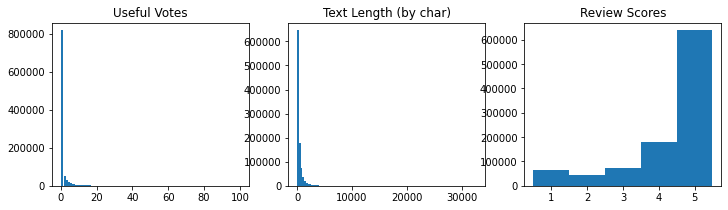

In [5]:
# Plot distributions of useful votes, text length and review scores
plt.figure(figsize=(12,3))
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,3))
ax1.hist(df['useful'], range=(0, 100), bins=100);
ax2.hist(df['text'].str.len(), bins=100);
ax3.hist(df['stars'], range=(0.5, 5.5), bins=5);
ax1.title.set_text('Useful Votes');
ax2.title.set_text('Text Length (by char)');
ax3.title.set_text('Review Scores');

In [6]:
# Count of reviews by useful votes
df["useful"].value_counts()[:20]

0     817046
2      49766
3      28965
4      18299
5      13018
6       9615
7       7438
8       5832
9       4889
10      4016
11      3410
12      2892
13      2542
14      2188
15      1991
16      1751
17      1538
18      1390
19      1241
20      1117
Name: useful, dtype: int64

In [7]:
print("Oldest review: {}".format(df['date'].min()))
print("Latest review: {}".format(df['date'].max()))

Oldest review: 01 1, 2000
Latest review: 12 9, 2017


## Dataset Preparation

We treat the prediction of review usefulness as a binary classification task. Here, we define a useful review as one with >=9 useful votes.

In [8]:
# Threshold for deciding whether a review is useful or not
threshold = 9
useful_count = len(df[df['useful'] >= threshold]) # Count of reviews with >= X votes
useful_count

50021

In [9]:
# Construct balanced dataset by downsampling non-useful reviews
# Can consider upsampling useful reviews instead if we have enough capacity to train lots of data on Colab
balanced_df = df[df['useful'] >= threshold].sample(50000, random_state = seed)
balanced_df = pd.concat([balanced_df, df[df['useful'] < threshold].sample(50000, random_state = seed)])
balanced_df

,useful,stars,text,date
181986,9,4.0,Whoa! What a neat package. Simple mic with j...,"07 15, 2011"
784109,17,5.0,This is a great camcorder. I use the highest q...,"06 18, 2008"
130169,29,5.0,"After extensive research, I decided on this ca...","03 28, 2003"
388072,15,1.0,Ordered this Tiffin filter as part of the purc...,"01 21, 2011"
812642,14,2.0,This would be a great network appliance if I w...,"04 23, 2008"
...,...,...,...,...
109878,0,3.0,A portable device with more bulk than expected...,"11 30, 2007"
662412,0,4.0,Thanx,"12 27, 2014"
404,0,5.0,"Great mount used it on my ""32 TV and not I can...","07 27, 2015"
763804,0,5.0,The memory card reader works great and is easy...,"10 3, 2013"


In [0]:
# Split into train/dev/test at 80%/10%/10%
df2 = balanced_df.drop(labels=["date"], axis=1)
df2 = df2.reindex(columns=["text", "useful", "stars"])
df2['useful'] = np.where(df2['useful'] >= threshold, 1, 0) # Convert 'useful' into binary labels
df2['stars'] = df2['stars'].astype('long')

train, val, test = np.split(df2.sample(frac=1, random_state=seed), [int(.8*len(df2)), int(.9*len(df2))])

In [11]:
train

,text,useful,stars
597703,Let me start by saying that I am picky and a b...,1,3
862033,Just wanted a non-cable TV for kitchen. Doesn...,0,3
823996,I purchased this to connect a pair of headphon...,0,5
255531,I purchased the MDX1600 to work on improving t...,1,5
665792,"If you order a lot of CDs from Amazon, then we...",1,5
...,...,...,...
621925,haven't used it yet its in my earth quake disa...,0,4
8633,Bought this for a spare just in case.....It lo...,0,5
529362,"It is ok, but it is slap when it us connected.",0,3
360247,Excellent radio and reception in this mostly r...,1,5


<font color='red'>**TARGET**</font>

Here, we define the target with which the model will train on. To train the model on review sentiment, set target to 'stars'.

In [0]:
target = 'useful'

## Pre-processing

<font color='red'>**SPLIT_SENTENCES**</font>

Since a document can be viewed as having a hierarchical structure where words forms sentences, and sentences form the document, we will require the sentences to be split. We set a flag here so we can choose to treat the entire document as a single data point for other attention models which treats a document as a single entity of words.

In [0]:
# Whether to split sentences or not (True for HAN, False for other attention models)
split_sentences = True

In [0]:
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()

# Split each review into sentences
def generate_texts_sents(dataset):
  texts_sents = []
  for doc in dataset:
      texts_sents.append(tokenizer.tokenize(doc))
  return texts_sents

In [15]:
if split_sentences:
    # Split each review into sentences
    train_texts_sents = generate_texts_sents(train.text.tolist())
    val_texts_sents = generate_texts_sents(val.text.tolist())
    test_texts_sents = generate_texts_sents(test.text.tolist())

    # Flatten all sentences in reviews into 1 long list of sentences
    train_all_sents = [s for sents in train_texts_sents for s in sents]
    val_all_sents = [s for sents in val_texts_sents for s in sents]
    test_all_sents = [s for sents in test_texts_sents for s in sents]

    # Save the lengths of the documents: 1) for padding purposes and 2) to compute consecutive ranges 
    # so we can "fold" the list again
    train_texts_length = [0] + [len(s) for s in train_texts_sents]
    val_texts_length = [0] + [len(s) for s in val_texts_sents]
    test_texts_length = [0] + [len(s) for s in test_texts_sents]

    train_range_idx = [sum(train_texts_length[: i + 1]) for i in range(len(train_texts_length))]
    val_range_idx = [sum(val_texts_length[: i + 1]) for i in range(len(val_texts_length))]
    test_range_idx = [sum(test_texts_length[: i + 1]) for i in range(len(test_texts_length))]

    print(val_texts_sents[0])

['At the suggested retail price, I would never have made this purchase, but because it was a reasonable Gold Box offer, I leapt toward my first bluetooth earpiece.', "The pink was not a selling point, but I preferred that to a more common black contraption, and I'm not at all disappointed.", "It's more of a mauve than pink which was more pleasing to me.", 'It synched up immediately with my cell phone and I suspect it will do the same when this phone is replaced in 2009.', 'The manual was easy to read and understand and I had no difficulty placing the earpiece into the lovely leather carrying case/charger or removing it to use.', 'Although some have complained about short battery time, I have not experienced that and have not have the battery die at any time.', 'It is easy to check the battery level by depressing the two buttons on the device and observing the number of red flashes for remaining power.', "The small size might be easy to lose for some, but I'm aware of that possibility a

In [0]:
# Convert to lowercase / Remove accent marks / Limit min & max length of token
def simple_preprocess(doc, lower=True, deacc=False, min_len=2, max_len=15):
    tokens = [
        token
        for token in tokenize(doc, lower=lower, deacc=deacc, errors="ignore")
        # if min_len <= len(token) <= max_len and not token.startswith("_")
    ]
    return tokens

# Generate word tokens for review
def tokenize_review(texts, with_preprocess=True):
    if with_preprocess:
        texts = [" ".join(simple_preprocess(s)) for s in texts]
    tokenizer = Tokenizer()
    tok = SpacyTokenizer('en')
    tokens = []
    for text in texts:
      tokens.append(tokenizer.process_text(text, tok))
    return tokens

In [17]:
if split_sentences:
  train_sents_tokens = tokenize_review(train_all_sents)
  val_sents_tokens = tokenize_review(val_all_sents)
  test_sents_tokens = tokenize_review(test_all_sents)
  print(val_sents_tokens[0])
else: 
  train_tokens = tokenize_review(train.text.tolist())
  val_tokens = tokenize_review(val.text.tolist())
  test_tokens = tokenize_review(test.text.tolist())
  print(val_tokens[0])

['at', 'the', 'suggested', 'retail', 'price', 'i', 'would', 'never', 'have', 'made', 'this', 'purchase', 'but', 'because', 'it', 'was', 'a', 'reasonable', 'gold', 'box', 'offer', 'i', 'leapt', 'toward', 'my', 'first', 'bluetooth', 'earpiece']


In [0]:
# Create Vocabulary using fastai's Vocab class
vocab = Vocab.create(train_sents_tokens if split_sentences else train_tokens, max_vocab=10000, min_freq=5)

In [19]:
if split_sentences:
  # 'numericalize' each sentence
  train_sents_numz = [vocab.numericalize(s) for s in train_sents_tokens]
  val_sents_numz = [vocab.numericalize(s) for s in val_sents_tokens]
  test_sents_numz = [vocab.numericalize(s) for s in test_sents_tokens]

  # group the sentences again into documents
  train_texts_numz = [train_sents_numz[train_range_idx[i] : train_range_idx[i + 1]] for i in range(len(train_range_idx[:-1]))]
  val_texts_numz = [val_sents_numz[val_range_idx[i] : val_range_idx[i + 1]] for i in range(len(val_range_idx[:-1]))]
  test_texts_numz = [test_sents_numz[test_range_idx[i] : test_range_idx[i + 1]] for i in range(len(test_range_idx[:-1]))]

  print(val_texts_numz[0])
else:
  train_texts_numz = [vocab.numericalize(s) for s in train_tokens]
  val_texts_numz = [vocab.numericalize(s) for s in val_tokens]
  test_texts_numz = [vocab.numericalize(s) for s in test_tokens]

  print(val_texts_numz[0])

[[38, 9, 2439, 2262, 89, 10, 61, 212, 25, 193, 17, 317, 26, 93, 14, 32, 11, 1167, 2154, 237, 1113, 10, 0, 3097, 24, 114, 855, 3776], [9, 3545, 32, 27, 11, 1498, 263, 26, 10, 2496, 21, 12, 11, 57, 1320, 411, 9873, 13, 10, 84, 27, 38, 41, 712], [14, 28, 57, 16, 11, 0, 62, 3545, 69, 32, 57, 2708, 12, 66], [14, 0, 49, 958, 22, 24, 1078, 384, 13, 10, 1951, 14, 50, 75, 9, 142, 48, 17, 384, 15, 846, 20], [9, 271, 32, 124, 12, 243, 13, 878, 13, 10, 60, 58, 2783, 3268, 9, 3776, 109, 9, 4439, 1763, 1009, 148, 570, 37, 2050, 14, 12, 44], [385, 73, 25, 2249, 64, 459, 122, 79, 10, 25, 27, 1476, 21, 13, 25, 27, 25, 9, 122, 2617, 38, 85, 79], [14, 15, 124, 12, 705, 9, 122, 439, 82, 8514, 9, 112, 410, 23, 9, 195, 13, 6480, 9, 534, 16, 787, 2271, 18, 2901, 126], [9, 135, 205, 313, 34, 124, 12, 1116, 18, 73, 26, 10, 84, 1408, 16, 21, 4393, 13, 4008, 3178, 48, 10, 227, 14, 20, 24, 259, 37, 537], [93, 16, 21, 135, 205, 14, 392, 68, 11, 339, 12, 287, 9, 3776, 109, 9, 415, 13, 10, 75, 27, 998, 14, 543, 10, 

In [20]:
# Validate tokenisation and vocab building works
if split_sentences:
  print(val_sents_tokens[0])
  print([vocab.itos[i] for i in val_texts_numz[0][0]])
else:
  print(val_tokens[0])
  print([vocab.itos[i] for i in val_texts_numz[0]])

['at', 'the', 'suggested', 'retail', 'price', 'i', 'would', 'never', 'have', 'made', 'this', 'purchase', 'but', 'because', 'it', 'was', 'a', 'reasonable', 'gold', 'box', 'offer', 'i', 'leapt', 'toward', 'my', 'first', 'bluetooth', 'earpiece']
['at', 'the', 'suggested', 'retail', 'price', 'i', 'would', 'never', 'have', 'made', 'this', 'purchase', 'but', 'because', 'it', 'was', 'a', 'reasonable', 'gold', 'box', 'offer', 'i', 'xxunk', 'toward', 'my', 'first', 'bluetooth', 'earpiece']


We restrict the max sentence length and document length using 80th quantile.

In [21]:

q=0.8

if split_sentences:
  train_sents_length = [len(s) for s in train_sents_tokens]
  maxlen_sent = int(np.quantile(train_sents_length, q=q))
  maxlen_doc  = int(np.quantile(train_texts_length, q=q))

  print("Max Sentence Length: {}".format(maxlen_sent))
  print("Max Document Length: {}".format(maxlen_doc))
else:
  train_length = [len(s) for s in train_tokens]
  maxlen_sent  = int(np.quantile(train_length, q=q))
  maxlen_doc = 1
  print("Max Review Length: {}".format(maxlen_sent))

Max Sentence Length: 24
Max Document Length: 15


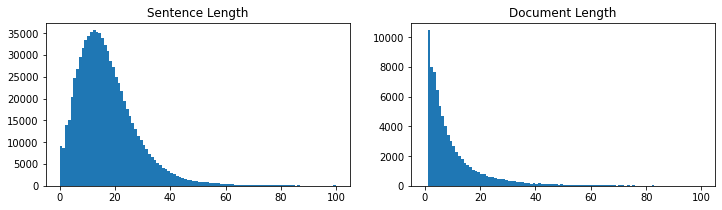

In [22]:
# Distribution of sentence and document length

if split_sentences:
  f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))
  ax1.hist(train_sents_length, range=(0, 100), bins=100);
  ax2.hist(train_texts_length, range=(0, 100), bins=100);
  ax1.title.set_text('Sentence Length');
  ax2.title.set_text('Document Length');
else:
  f, (ax1) = plt.subplots(1,1, figsize=(12,3))
  ax1.hist(train_length, range=(0, 1000), bins=100);
  ax1.title.set_text('Review Length');

In [0]:
def pad_sequences(seq, maxlen, pad_first=False, pad_idx=1):
    if len(seq) >= maxlen:
        res = np.array(seq[-maxlen:]).astype("int32")
        return res
    else:
        res = np.zeros(maxlen, dtype="int32") + pad_idx
        if pad_first:
            res[-len(seq) :] = seq
        else:
            res[: len(seq) :] = seq
        return res


def pad_nested_sequences(
    seq, maxlen_sent, maxlen_doc, pad_sent_first=False, pad_doc_first=False, pad_idx=1
):
    seq = [s for s in seq if len(s) >= 1]
    if len(seq) == 0:
        return np.array([[pad_idx] * maxlen_sent] * maxlen_doc).astype("int32")
    seq = [pad_sequences(s, maxlen_sent, pad_sent_first, pad_idx) for s in seq]
    if len(seq) >= maxlen_doc:
        return np.array(seq[:maxlen_doc])
    else:
        res = np.array([[pad_idx] * maxlen_sent] * maxlen_doc).astype("int32")
        if pad_doc_first:
            res[-len(seq) :] = seq
        else:
            res[: len(seq) :] = seq
        return res

def pad_single_sequence(
    seq, maxlen, pad_sent_first=False, pad_doc_first=False, pad_idx=1
):
    # seq = [s for s in seq if len(s) >= 1]
    if len(seq) == 0:
        return np.array([pad_idx] * maxlen).astype("int32")
    seq = pad_sequences(seq, maxlen, pad_sent_first, pad_idx)

    if len(seq) >= maxlen:
        return np.array(seq[:maxlen])
    else:
        res = np.array([pad_idx] * maxlen).astype("int32")
        if pad_doc_first:
            res[-len(seq) :] = seq
        else:
            res[: len(seq) :] = seq
        return res

In [24]:
if split_sentences:
  train_padded_texts = np.stack([pad_nested_sequences(r, maxlen_sent, maxlen_doc) for r in train_texts_numz], axis=0)
  val_padded_texts = np.stack([pad_nested_sequences(r, maxlen_sent, maxlen_doc) for r in val_texts_numz], axis=0)
  test_padded_texts = np.stack([pad_nested_sequences(r, maxlen_sent, maxlen_doc) for r in test_texts_numz], axis=0)

else:
  train_padded_texts = np.stack([pad_single_sequence(r, maxlen_sent) for r in train_texts_numz], axis=0)
  val_padded_texts = np.stack([pad_single_sequence(r, maxlen_sent) for r in val_texts_numz], axis=0)
  test_padded_texts = np.stack([pad_single_sequence(r, maxlen_sent) for r in test_texts_numz], axis=0)

print(val_padded_texts.shape)
print(val_padded_texts[0])

(10000, 15, 24)
[[  89   10   61  212 ...   24  114  855 3776]
 [   9 3545   32   27 ...   27   38   41  712]
 [  14   28   57   16 ...    1    1    1    1]
 [  14    0   49  958 ...  846   20    1    1]
 ...
 [  20 1145   10   55 ...   43   24  415    1]
 [  10   91  118   17 ...    1    1    1    1]
 [   1    1    1    1 ...    1    1    1    1]
 [   1    1    1    1 ...    1    1    1    1]]


## Load into PyTorch DataLoader and Create Embeddings Matrix

In [0]:
from torch.utils.data import TensorDataset, DataLoader

In [26]:
batch_size = 64

train_set = TensorDataset(torch.from_numpy(train_padded_texts), torch.from_numpy(train[target].to_numpy()))
train_loader = DataLoader(dataset=train_set, batch_size=batch_size)
val_set = TensorDataset(torch.from_numpy(val_padded_texts), torch.from_numpy(val[target].to_numpy()))
val_loader = DataLoader(dataset=val_set, batch_size=batch_size)
test_set = TensorDataset(torch.from_numpy(test_padded_texts), torch.from_numpy(test[target].to_numpy()))
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)

next(iter(train_loader))

[tensor([[[ 424,   66,  531,  ...,   27, 1435,   19],
          [  24, 1001,   64,  ..., 1147,  177,  316],
          [  98,   21,   21,  ...,    1,    1,    1],
          ...,
          [  48,   10,  940,  ...,    9, 4246,    1],
          [ 184,   10,  203,  ...,    1,    1,    1],
          [ 825, 6018,   15,  ...,   20,    9,  299]],
 
         [[  51,  314,   11,  ...,    1,    1,    1],
          [ 191,   29,  819,  ...,    1,    1,    1],
          [  19,  564,   18,  ...,    1,    1,    1],
          ...,
          [   1,    1,    1,  ...,    1,    1,    1],
          [   1,    1,    1,  ...,    1,    1,    1],
          [   1,    1,    1,  ...,    1,    1,    1]],
 
         [[  10,  240,   17,  ...,    1,    1,    1],
          [   1,    1,    1,  ...,    1,    1,    1],
          [   1,    1,    1,  ...,    1,    1,    1],
          ...,
          [   1,    1,    1,  ...,    1,    1,    1],
          [   1,    1,    1,  ...,    1,    1,    1],
          [   1,    1,    1,  .

In [0]:
def build_embeddings_matrix(vocab, word_vectors_path, verbose=1):
    r"""
    Build the embedding matrix using pretrained word vectors
    Parameters
    ----------
    vocab: Fastai's Vocab object
        see: https://docs.fast.ai/text.transform.html#Vocab
    word_vectors_path:str
        path to the pretrained word embeddings
    verbose: Int. Default=1
    Returns
    -------
    embedding_matrix: np.ndarray
        pretrained word embeddings. If a word in our vocabulary is not among the
        pretrained embeddings it will be assigned the mean pretrained
        word-embeddings vector
    """
    # if not os.path.isfile(word_vectors_path):
    #     raise FileNotFoundError("{} not found".format(word_vectors_path))
    if verbose: print('Indexing word vectors...')

    embeddings_index = {}
    f = open(word_vectors_path)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    if verbose:
        print('Loaded {} word vectors'.format(len(embeddings_index)))
        print('Preparing embeddings matrix...')

    mean_word_vector = np.mean(list(embeddings_index.values()), axis=0)
    embedding_dim = len(list(embeddings_index.values())[0])
    num_words = len(vocab.itos)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    found_words=0
    for i,word in enumerate(vocab.itos):
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            found_words+=1
        else:
            embedding_matrix[i] = mean_word_vector

    return embedding_matrix

In [28]:
embeddings_matrix = build_embeddings_matrix(vocab, path + 'glove.6B.300d.txt')
embeddings_matrix.shape

Indexing word vectors...
Loaded 400000 word vectors
Preparing embeddings matrix...


(10000, 300)

## Model: HAN

In [0]:
class AttentionWithContext(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionWithContext, self).__init__()

        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.contx = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, inp):
        # Calculate alignment scores
        u = torch.tanh_(self.attn(inp))
        # Using softmax to calculate attn_weights
        a = F.softmax(self.contx(u), dim=1)
        # Using dot product to calculate output
        s = (a * inp).sum(1)
        # Return normalized importance weights
        return a.permute(0, 2, 1), s

In [0]:
class WordAttnNet(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_dim=32,
        padding_idx=1,
        embed_dim=50,
        embedding_matrix=None,
        embed_drop=0.0,
        weight_drop=0.0,
    ):
        super(WordAttnNet, self).__init__()

        if isinstance(embedding_matrix, np.ndarray):
            self.word_embed = nn.Embedding(
                vocab_size, embedding_matrix.shape[1], padding_idx=padding_idx
            )
            self.word_embed.weight = nn.Parameter(torch.Tensor(embedding_matrix))
            embed_dim = embedding_matrix.shape[1]
        else:
            self.word_embed = nn.Embedding(vocab_size, embed_dim, padding_idx=padding_idx)

        if embed_drop:
            self.word_embed = EmbeddingDropout(self.word_embed, embed_drop)

        self.rnn = nn.GRU(embed_dim, hidden_dim, bidirectional=True, batch_first=True)

        if weight_drop:
            self.rnn = WeightDropout(self.rnn, weight_drop)

        self.word_attn = AttentionWithContext(hidden_dim * 2)

    def forward(self, X, h_n):
        embed = self.word_embed(X.long())
        h_t, h_n = self.rnn(embed, h_n)
        a, s = self.word_attn(h_t)
        return a, s.unsqueeze(1), h_n

In [0]:
class SentAttnNet(nn.Module):
    def __init__(
        self, 
        word_hidden_dim=32, 
        sent_hidden_dim=32, 
        padding_idx=1,
        weight_drop=0.0,
    ):
        super(SentAttnNet, self).__init__()

        self.rnn = nn.GRU(
            word_hidden_dim * 2, sent_hidden_dim, bidirectional=True, batch_first=True
        )

        if weight_drop:
            self.rnn = WeightDropout(self.rnn, weight_drop)

        self.sent_attn = AttentionWithContext(sent_hidden_dim * 2)

    def forward(self, X):
        h_t, h_n = self.rnn(X)
        a, v = self.sent_attn(h_t)
        return a.permute(0,2,1), v

In [0]:
class HierAttnNet(nn.Module):
    def __init__(
        self,
        vocab_size,
        maxlen_sent,
        maxlen_doc,
        word_hidden_dim=32,
        sent_hidden_dim=32,
        padding_idx=1,
        embed_dim=50,
        weight_drop=0.0,
        embed_drop=0.0,
        last_drop=0.0,
        embedding_matrix=None,
        num_class=2,
    ):
        super(HierAttnNet, self).__init__()

        self.word_hidden_dim = word_hidden_dim

        self.wordattnnet = WordAttnNet(
            vocab_size=vocab_size,
            hidden_dim=word_hidden_dim,
            padding_idx=padding_idx,
            embed_dim=embed_dim,
            embedding_matrix=embedding_matrix,
            embed_drop=embed_drop,
            weight_drop=weight_drop,
        )

        self.sentattnnet = SentAttnNet(
            word_hidden_dim=word_hidden_dim,
            sent_hidden_dim=sent_hidden_dim,
            padding_idx=padding_idx,
            weight_drop=weight_drop,
        )

        self.ld = nn.Dropout(last_drop)
        self.fc = nn.Linear(sent_hidden_dim * 2, num_class)

    def forward(self, X):
        x = X.permute(1, 0, 2)
        word_h_n = torch.zeros((2,X.shape[0],self.word_hidden_dim))
        if use_cuda:
            word_h_n = word_h_n.cuda()
        # alpha and s Tensor Lists
        word_a_list, word_s_list = [], []
        for sent in x:
            word_a, word_s, word_h_n = self.wordattnnet(sent, word_h_n)
            word_a_list.append(word_a)
            word_s_list.append(word_s)
        # Importance attention weights per word in sentence
        self.sent_a = torch.cat(word_a_list, 1)
        # Sentences representation
        sent_s = torch.cat(word_s_list, 1)
        # Importance attention weights per sentence in doc and document representation
        self.doc_a, doc_s = self.sentattnnet(sent_s)
        # Dropout
        doc_s = self.ld(doc_s)
        return self.fc(doc_s)

In [33]:
m = HierAttnNet(
    vocab_size=len(vocab.stoi),
    maxlen_sent=maxlen_sent,
    maxlen_doc=maxlen_doc,
    word_hidden_dim=32,
    sent_hidden_dim=32,
    padding_idx=1,
    embed_dim=300,
    weight_drop=0.8,
    embed_drop=0.8,
    last_drop=0.8,
    embedding_matrix=embeddings_matrix,
    num_class=2,
)

if use_cuda:
    m = m.cuda()

m

HierAttnNet(
  (wordattnnet): WordAttnNet(
    (word_embed): EmbeddingDropout(
      (emb): Embedding(74813, 300, padding_idx=1)
    )
    (rnn): WeightDropout(
      (module): GRU(300, 32, batch_first=True, bidirectional=True)
    )
    (word_attn): AttentionWithContext(
      (attn): Linear(in_features=64, out_features=64, bias=True)
      (contx): Linear(in_features=64, out_features=1, bias=False)
    )
  )
  (sentattnnet): SentAttnNet(
    (rnn): WeightDropout(
      (module): GRU(64, 32, batch_first=True, bidirectional=True)
    )
    (sent_attn): AttentionWithContext(
      (attn): Linear(in_features=64, out_features=64, bias=True)
      (contx): Linear(in_features=64, out_features=1, bias=False)
    )
  )
  (ld): Dropout(p=0.8, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

## Training

Definition of training loop, where we return the model at the lowest validation loss during training

In [0]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs, batch_size):
    measurements = {
        "Train Loss": [],
        "Train Acc": [],
        "Train F1": [],
        "Val Loss": [],
        "Val Acc": [],
        "Val F1": [],
        "Lowest Val Loss": np.Inf,
        "Lowest Val Loss Epoch": np.Inf
    }
    lowest_val_loss = np.Inf
    lowest_val_loss_epoch = np.Inf
    
    for epoch in range(1, epochs+1):
        # Training
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0  
        
        model.train() # Set model in train mode
        
        for X,y in iter(train_dl):
            X = X.cuda() if use_cuda else X
            y = y.cuda() if use_cuda else y

            opt.zero_grad() # Clear old gradients
            pred = model(X) # Make prediction using model
            loss = loss_fn(pred, y)
            loss.backward() # Compute derivatives of loss w.r.t. parameters using backpropagation
            opt.step() # Take a step using computed gradients
            pred_idx = torch.max(pred, 1)[1]
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred_idx.cpu().data.numpy())
            total_loss_train += loss.item()
        
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_f1 = f1_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        measurements["Train Acc"].append(train_acc)
        measurements["Train F1"].append(train_f1)
        measurements["Train Loss"].append(train_loss)
        
        # Validation
        y_true_val = list()
        y_pred_val = list()
        total_loss_val = 0
        
        model.eval() # Set model in eval mode

        for X,y in iter(val_dl):
            X = X.cuda() if use_cuda else X
            y = y.cuda() if use_cuda else y

            pred = model(X)
            loss = loss_fn(pred, y)
            pred_idx = torch.max(pred, 1)[1]

            y_true_val += list(y.cpu().data.numpy())
            y_pred_val += list(pred_idx.cpu().data.numpy())
            total_loss_val += loss.item()

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1 = f1_score(y_true_val, y_pred_val)
        val_loss = total_loss_val/len(val_dl)
        measurements["Val Acc"].append(val_acc)
        measurements["Val F1"].append(val_f1)
        measurements["Val Loss"].append(val_loss)
        
        if (val_loss < measurements["Lowest Val Loss"]):
            torch.save(model.state_dict(), path + model_name + '_checkpoint.pt')
            measurements["Lowest Val Loss"] = val_loss
            measurements["Lowest Val Loss Epoch"] = epoch
        
        print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} train_f1: {train_f1:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f} val_f1: {val_f1:.4f}')
        
    # Return model checkpoint stored at lowest validation loss
    model.load_state_dict(torch.load(path + model_name + '_checkpoint.pt'))
    print(f'Lowest val_loss: {measurements["Lowest Val Loss"]:.4f}, at epoch {measurements["Lowest Val Loss Epoch"]}')
    
    return model, measurements

In [35]:
opt = torch.optim.AdamW(m.parameters())
m, measurements = fit(
    model=m,
    train_dl=train_loader, 
    val_dl=val_loader, 
    loss_fn=F.cross_entropy,
    opt=opt,
    epochs=20,
    batch_size=batch_size)

Epoch 1: train_loss: 0.4727 train_acc: 0.7860 train_f1: 0.7905 | val_loss: 0.4460 val_acc: 0.7931 val_f1: 0.8068
Epoch 2: train_loss: 0.4526 train_acc: 0.7952 train_f1: 0.8009 | val_loss: 0.4313 val_acc: 0.8000 val_f1: 0.8128
Epoch 3: train_loss: 0.4488 train_acc: 0.7988 train_f1: 0.8047 | val_loss: 0.4303 val_acc: 0.8020 val_f1: 0.8180
Epoch 4: train_loss: 0.4445 train_acc: 0.7990 train_f1: 0.8049 | val_loss: 0.4200 val_acc: 0.8043 val_f1: 0.8152
Epoch 5: train_loss: 0.4440 train_acc: 0.7981 train_f1: 0.8045 | val_loss: 0.4165 val_acc: 0.8057 val_f1: 0.8131
Epoch 6: train_loss: 0.4409 train_acc: 0.8018 train_f1: 0.8077 | val_loss: 0.4170 val_acc: 0.8071 val_f1: 0.8174
Epoch 7: train_loss: 0.4381 train_acc: 0.8016 train_f1: 0.8076 | val_loss: 0.4182 val_acc: 0.8077 val_f1: 0.8163
Epoch 8: train_loss: 0.4392 train_acc: 0.8004 train_f1: 0.8069 | val_loss: 0.4161 val_acc: 0.8056 val_f1: 0.8156
Epoch 9: train_loss: 0.4369 train_acc: 0.8029 train_f1: 0.8090 | val_loss: 0.4154 val_acc: 0.810

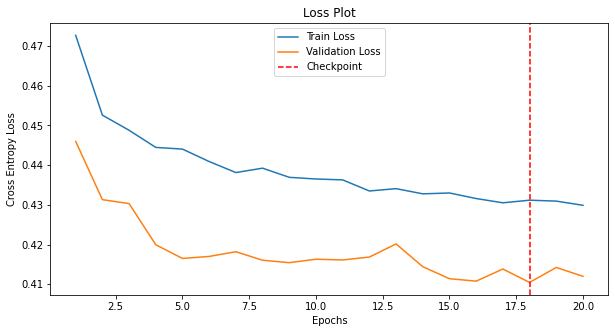

In [36]:
plt.figure(figsize=(10,5))
plt.plot(range(1,21), measurements["Train Loss"], label="Train Loss")
plt.plot(range(1,21), measurements["Val Loss"], label="Validation Loss")
plt.axvline(measurements["Lowest Val Loss Epoch"], linestyle='--', color='r',label='Checkpoint')
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()

## Test Accuracy and Attention Visualisation

In [0]:
def get_predictions_and_attn_weights(model, test_loader):
    model.eval()
    preds, sent_a, doc_a = [], [], []
    with torch.no_grad():
        for data, target in test_loader:
            X = data.cuda() if use_cuda else data
            y_pred = model(X)
            preds.append(y_pred)
            sent_a.append(model.sent_a)
            doc_a.append(model.doc_a)
    return preds, sent_a, doc_a

In [0]:
import matplotlib

def plot_attention(doc, word_w, doc_w):
    word_cmap = matplotlib.cm.get_cmap("Greens")
    sent_cmap = matplotlib.cm.get_cmap("Reds")
    template = '<font face="monospace" \nsize="3"; span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_doc = ""
    for sent, sent_w, whole_sent_w in zip(doc, word_w, doc_w):
        sent_len, pad_count = len(sent.split()), 0
        sentence_fmt = ""
        sent_color = matplotlib.colors.rgb2hex(sent_cmap(whole_sent_w)[:3])
        
        for t, w in zip(sent.split(), sent_w):
            if t == 'xxpad':
                pad_count+=1
                continue
            word_color = matplotlib.colors.rgb2hex(word_cmap(w)[:3])
            sentence_fmt += template.format(word_color, "&nbsp" + t +"&nbsp")
        if pad_count != sent_len:
            sentence_fmt += "</br>"
            sentence_fmt = template.format(sent_color, "&nbsp&nbsp&nbsp") + sentence_fmt
        colored_doc += sentence_fmt
        
    return colored_doc

In [0]:
preds_l, word_attn_l, sent_attn_l = get_predictions_and_attn_weights(m, test_loader)

preds = F.softmax(torch.cat(preds_l), 1).cpu().numpy() # Probabilities of being not useful & useful [0,1] per example
word_attn = torch.cat(word_attn_l).cpu().numpy()
sent_attn = torch.cat(sent_attn_l).squeeze(2).cpu().numpy()

In [40]:
y_true = test[target].to_numpy()
y_pred = np.argmax(preds, axis=1)
print('Test Accuracy: {}'.format(accuracy_score(y_true, y_pred)))
print('Test F1: {}'.format(f1_score(y_true, y_pred)))

Test Accuracy: 0.8121
Test F1: 0.8160548213411649


In [0]:
def get_indices(y_true, y_preds, n=1, agree=True, is_pos=True):
    pred_pos = np.where(y_preds[:, 1] > 0.9)[0]
    true_pos = np.where(y_true == 1)[0]
    pred_neg = np.where(y_preds[:, 0] > 0.9)[0] 
    true_neg = np.where(y_true == 0)[0]
    # if prediction and real agree
    if agree:
        # if real is positive
        if is_pos:
            idx = np.random.choice(np.intersect1d(pred_pos, true_pos), n)[0]
        else: 
            idx = np.random.choice(np.intersect1d(pred_neg, true_neg), n)[0]
    else:
        if is_pos:
            idx = np.random.choice(np.intersect1d(pred_neg, true_pos), n)[0]  
        else: 
            idx = np.random.choice(np.intersect1d(pred_pos, true_neg), n)[0]  
    return idx

In [0]:
idx = get_indices(y_true, preds)
idx = 999

doc = [vocab.textify(s) for s in test_padded_texts[idx]]
word_w = word_attn[idx]
doc_w  = sent_attn[idx]

In [0]:
pred_pos_real_pos_attn = plot_attention(doc, word_w, doc_w)
with open('/tmp/pred_pos_real_pos_attn.html', 'w') as f:
    f.write(pred_pos_real_pos_attn)

In [65]:
from IPython.display import display, HTML
display(HTML('/tmp/pred_pos_real_pos_attn.html'))

## Top word & sentence attention weights

In [45]:
# Top 10 average word attention weights

avg_weights = {}
for i, review in enumerate(test_padded_texts):
  word_weights = word_attn[i]
  doc = [vocab.textify(s) for s in test_padded_texts[i]]

  for j in range(word_weights.shape[0]):
    words_in_sentence = doc[j].split()
    for k in range(word_weights.shape[1]):
      if len(words_in_sentence) < word_weights.shape[1]:
        continue
      word = words_in_sentence[k]
      if word == 'xxpad':
        continue
      if word in avg_weights:
        avg_weights[word] = (avg_weights[word][0] + word_weights[j][k], avg_weights[word][1] + 1)
      else:
        avg_weights[word] = (word_weights[j][k], 1)

for k,v in avg_weights.items():
  avg_weights[k] = v[0] / v[1]

sorted(avg_weights.items(), key=lambda item: item[1], reverse=True)[:10]

[('hmm', 0.7288912534713745),
 ('skinny', 0.673136830329895),
 ('discwasher', 0.6393969655036926),
 ('overrated', 0.5942797660827637),
 ('positives', 0.5590387344360351),
 ('lol', 0.5450962066650391),
 ('snowflake', 0.5320731401443481),
 ('bravo', 0.5173042416572571),
 ('excelente', 0.5091871193477085),
 ('skyfi', 0.5024579763412476)]

In [46]:
# Top 10 sentence attention weights

sent_weights = {}

for i, review in enumerate(test_padded_texts):
    sent_atten_per_doc = sent_attn[i]
    doc = [vocab.textify(s) for s in test_padded_texts[i]]

    for j in range(len(sent_atten_per_doc)):
        words_in_sentence = doc[j].split()
        words_in_sentence = list(filter(lambda a: a != 'xxpad', words_in_sentence))
        original_sentence = " ".join(x for x in words_in_sentence)
        sent_weights[original_sentence] = sent_atten_per_doc[j]

sorted(sent_weights.items(), key=lambda item: item[1], reverse=True)[:10]

[('type keyboards no trouble using the keyboard with any computer with a ps connector but the usb converter is not xxunk with the dell',
  0.7448734),
 ('wallet but looks ok and performs ok i rarely have to point it anywhere i m in north xxunk in order to get reception',
  0.74380964),
 ('and one cable to the y splitter the signal will bounce in the cable and produce really ugly ghosting of edges in the image',
  0.7385943),
 ('makes it easy to hall my gear around town xxunk on my f and fx but xxunk not fit the f bag and strap',
  0.73735064),
 ('and smells good in your car or truck has good dimensions for the that i bought any questions email me at xxunk yahoo com',
  0.7371715),
 ('lens will not zoom in and out as it should the money that paid for this lens i would like to have it working',
  0.7364107),
 ('of space between lcd plasma screen and the wall as it will stick out inch and you still need inch for the power plug',
  0.7361024),
 ('work right out of the box with ubuntu no ne

## Word Level Analysis

In [47]:
from nltk.stem import WordNetLemmatizer
nltk.download('universal_tagset')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
count=500

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [48]:
# Distribution of POS tags of top attended words using NLTK
top_attended_words = sorted(avg_weights.items(), key=lambda item: item[1], reverse=True)[:count]
top_attended_words = [w[0] for w in top_attended_words]
# print(top_attended_words)
top_pos_tags = [w[1] for w in nltk.pos_tag(top_attended_words, tagset='universal')]
df = pd.DataFrame(top_pos_tags)
df[0].value_counts()

NOUN    265
ADJ      99
VERB     97
ADV      32
ADP       3
X         3
DET       1
Name: 0, dtype: int64

In [49]:
# Distribution of POS tags of bottom attended words using NLTK
bottom_attended_words = sorted(avg_weights.items(), key=lambda item: item[1], reverse=False)[:count]
bottom_attended_words = [w[0] for w in bottom_attended_words]
# print(bottom_attended_words)
bottom_pos_tags = [w[1] for w in nltk.pos_tag(bottom_attended_words, tagset='universal')]
df = pd.DataFrame(bottom_pos_tags)
df[0].value_counts()

NOUN    207
VERB    156
ADJ     101
ADV      29
ADP       3
PRON      2
NUM       1
PRT       1
Name: 0, dtype: int64

In [50]:
# Distribution of POS tags of all words using NLTK
all_words = [w[0] for w in avg_weights.items()]
pos_tags = [w[1] for w in nltk.pos_tag(all_words, tagset='universal')]
df = pd.DataFrame(pos_tags)
df[0].value_counts()

NOUN    4583
VERB    2372
ADJ     2046
ADV      567
ADP      108
PRON      29
DET       21
NUM       18
X         13
PRT       12
CONJ      10
Name: 0, dtype: int64

In [51]:
state_verbs = ['adore','agree','appear','appreciate','be','believe','belong','concern','consist','contain','cost','deny','depend','deserve','detest','disagree','dislike','doubt','equal','feel','hate','have','hear','imagine','include','involve','know','lack','like','loathe','look','love','matter','mean','measure','mind','need','owe','own','possess','promise','realize','recognize','remember','resemble','satisfy','see','seem','smell','sound','suppose','surprise','taste','think','understand','want','weigh','wish']

lemmatized_top_attended_words = [lemmatizer.lemmatize(i) for i in top_attended_words]
lemmatized_bottom_attended_words = [lemmatizer.lemmatize(i) for i in bottom_attended_words]
lemmatized_all_words = [lemmatizer.lemmatize(i) for i in all_words]
print([i for i in lemmatized_top_attended_words if i in state_verbs])
print([i for i in lemmatized_bottom_attended_words if i in state_verbs])
print([i for i in lemmatized_all_words if i in state_verbs])

['deserve', 'smell']
['belong', 'wish', 'doubt']
['have', 'be', 'see', 'mean', 'think', 'sound', 'seem', 'cost', 'matter', 'surprise', 'include', 'imagine', 'look', 'want', 'need', 'love', 'like', 'lack', 'need', 'feel', 'own', 'feel', 'mind', 'lack', 'look', 'mean', 'believe', 'hate', 'know', 'want', 'hear', 'measure', 'cost', 'disagree', 'know', 'sound', 'love', 'depend', 'agree', 'wish', 'remember', 'surprise', 'see', 'concern', 'taste', 'recognize', 'doubt', 'understand', 'concern', 'think', 'suppose', 'realize', 'like', 'taste', 'equal', 'appear', 'matter', 'appreciate', 'measure', 'weigh', 'contain', 'satisfy', 'equal', 'owe', 'deserve', 'dislike', 'promise', 'belong', 'wish', 'smell', 'dislike', 'promise', 'smell', 'doubt', 'involve']


In [52]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('sentiwordnet')
nltk.download('punkt')
k=3

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [53]:
# Polarity/Subjectivity scores of all words using TextBlob

top_word_pola_scores = []
top_word_subj_scores = []
bottom_word_pola_scores = []
bottom_word_subj_scores = []
all_word_pola_scores = []
all_word_subj_scores = []

for sent in top_attended_words:
  s = TextBlob(sent)
  top_word_pola_scores.append(s.sentiment.polarity)
  top_word_subj_scores.append(s.sentiment.subjectivity)

for sent in bottom_attended_words:
  s = TextBlob(sent)
  bottom_word_pola_scores.append(s.sentiment.polarity)
  bottom_word_subj_scores.append(s.sentiment.subjectivity)

for sent in all_words:
  s = TextBlob(sent)
  all_word_pola_scores.append(s.sentiment.polarity)
  all_word_subj_scores.append(s.sentiment.subjectivity)

print('Top Polarity Mean: {}, Std: {}'.format(np.mean(top_word_pola_scores), np.std(top_word_pola_scores)))
print('Top Subjectivity Mean: {}, Std: {}'.format(np.mean(top_word_subj_scores), np.std(top_word_subj_scores)))
print('Bottom Polarity Mean: {}, Std: {}'.format(np.mean(bottom_word_pola_scores), np.std(bottom_word_pola_scores)))
print('Bottom Subjectivity Mean: {}, Std: {}'.format(np.mean(bottom_word_subj_scores), np.std(bottom_word_subj_scores)))
print('All Polarity Mean: {}, Std: {}'.format(np.mean(all_word_pola_scores), np.std(all_word_pola_scores)))
print('All Subjectivity Mean: {}, Std: {}'.format(np.mean(all_word_subj_scores), np.std(all_word_subj_scores)))

Top Polarity Mean: -0.00275, Std: 0.1216087476294366
Top Subjectivity Mean: 0.0346, Std: 0.16909417494402346
Bottom Polarity Mean: 0.0065393939393939395, Std: 0.09329751555936551
Bottom Subjectivity Mean: 0.03250909090909091, Std: 0.15240204115680447
All Polarity Mean: 0.0055830209887373205, Std: 0.12886528184288576
All Subjectivity Mean: 0.055258490103821944, Std: 0.19763752234526702


## Sentence Level Analysis

In [54]:
# Automated Readability Index
def ari(sentence):
    chars = len(sentence.replace(' ', ''))
    words = len(sentence.split(' '))
    return 4.71 * chars / words + 0.5 * words - 21.43

top_sentences = sorted(sent_weights.items(), key=lambda item: item[1], reverse=True)[:count]
top_sentences = [s[0] for s in top_sentences]

top_ari = [ari(s) for s in top_sentences]
print('Top Mean: {}, Std: {}'.format(np.mean(top_ari), np.std(top_ari)))

bottom_sentences = sorted(sent_weights.items(), key=lambda item: item[1], reverse=False)[:count]
bottom_sentences = [s[0] for s in bottom_sentences]

bottom_ari = [ari(s) for s in bottom_sentences]
print('Bottom Mean: {}, Std: {}'.format(np.mean(bottom_ari), np.std(bottom_ari)))

all_ari = [ari(s[0]) for s in sent_weights.items()]
print('All Mean: {}, Std: {}'.format(np.mean(all_ari), np.std(all_ari)))

Top Mean: 8.314571055649045, Std: 2.810831404651313
Bottom Mean: 2.858531696553447, Std: 6.39919667758775
All Mean: 5.834034933356928, Std: 4.443445941699827


In [0]:
top_attended_sents = sorted(sent_weights.items(), key=lambda item: item[1], reverse=True)[:100]
top_attended_sents = [w[0] for w in top_attended_sents]

bottom_attended_sents = sorted(sent_weights.items(), key=lambda item: item[1], reverse=False)[:100]
bottom_attended_sents = [w[0] for w in bottom_attended_sents]

all_attended_sents = [w[0] for w in sent_weights.items()]

In [56]:
# Sentence Polarity & Subjectivity using TextBlob
from textblob import TextBlob
top_sent_pola_scores = []
top_sent_subj_scores = []
bottom_sent_pola_scores = []
bottom_sent_subj_scores = []
all_sent_pola_scores = []
all_sent_subj_scores = []

for sent in top_attended_sents:
  s = TextBlob(sent)
  top_sent_pola_scores.append(s.sentiment.polarity)
  top_sent_subj_scores.append(s.sentiment.subjectivity)

for sent in bottom_attended_sents:
  s = TextBlob(sent)
  bottom_sent_pola_scores.append(s.sentiment.polarity)
  bottom_sent_subj_scores.append(s.sentiment.subjectivity)

for sent in all_attended_sents:
  s = TextBlob(sent)
  all_sent_pola_scores.append(s.sentiment.polarity)
  all_sent_subj_scores.append(s.sentiment.subjectivity)

print('Top Polarity Mean: {}, Std: {}'.format(np.mean(top_sent_pola_scores), np.std(top_sent_pola_scores)))
print('Top Subjectivity Mean: {}, Std: {}'.format(np.mean(top_sent_subj_scores), np.std(top_sent_subj_scores)))
print('Bottom Polarity Mean: {}, Std: {}'.format(np.mean(bottom_sent_pola_scores), np.std(bottom_sent_pola_scores)))
print('Bottom Subjectivity Mean: {}, Std: {}'.format(np.mean(bottom_sent_subj_scores), np.std(bottom_sent_subj_scores)))
print('All Polarity Mean: {}, Std: {}'.format(np.mean(all_sent_pola_scores), np.std(all_sent_pola_scores)))
print('All Subjectivity Mean: {}, Std: {}'.format(np.mean(all_sent_subj_scores), np.std(all_sent_subj_scores)))

Top Polarity Mean: 0.18950417619417617, Std: 0.29150043610142906
Top Subjectivity Mean: 0.44302264716764717, Std: 0.2774646488537869
Bottom Polarity Mean: 0.24083571428571432, Std: 0.3432976497951527
Bottom Subjectivity Mean: 0.380002380952381, Std: 0.3752056303109094
All Polarity Mean: 0.14996197400959196, Std: 0.29380648384717645
All Subjectivity Mean: 0.4007260598499362, Std: 0.306813019538775


## References

https://towardsdatascience.com/predicting-amazon-reviews-scores-using-hierarchical-attention-networks-with-pytorch-and-apache-5214edb3df20